In [2]:

!pip install requests beautifulsoup4 pandas seaborn matplotlib


In [6]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")


In [7]:
base_url = "http://books.toscrape.com/"
page_url = "http://books.toscrape.com/catalogue/page-1.html"
headers = {"User-Agent": "Mozilla/5.0"}

book_data = []

while True:
    print(f"Scraping: {page_url}")
    response = requests.get(page_url, headers=headers)
    soup = BeautifulSoup(response.content, "html.parser")

    books = soup.find_all("article", class_="product_pod")

    for book in books:
        title = book.h3.a["title"]
        price = book.find("p", class_="price_color").text
        availability = book.find("p", class_="instock availability").text.strip()
        rating_class = book.find("p", class_="star-rating")["class"]
        rating = rating_class[1]
        relative_url = book.h3.a["href"]
        product_url = base_url + "catalogue/" + relative_url.replace("../../../", "")

        book_data.append({
            "Title": title,
            "Price": price,
            "Availability": availability,
            "Rating": rating,
            "Product_URL": product_url
        })

    next_button = soup.find("li", class_="next")
    if next_button:
        next_page = next_button.a["href"]
        page_url = "http://books.toscrape.com/catalogue/" + next_page
    else:
        break

# Convert to DataFrame
df = pd.DataFrame(book_data)
df.to_csv("all_books.csv", index=False)

print("Scraping complete. Total books:", len(df))
df.head()


Scraping: http://books.toscrape.com/catalogue/page-1.html
Scraping: http://books.toscrape.com/catalogue/page-2.html
Scraping: http://books.toscrape.com/catalogue/page-3.html
Scraping: http://books.toscrape.com/catalogue/page-4.html
Scraping: http://books.toscrape.com/catalogue/page-5.html
Scraping: http://books.toscrape.com/catalogue/page-6.html
Scraping: http://books.toscrape.com/catalogue/page-7.html
Scraping: http://books.toscrape.com/catalogue/page-8.html
Scraping: http://books.toscrape.com/catalogue/page-9.html
Scraping: http://books.toscrape.com/catalogue/page-10.html
Scraping: http://books.toscrape.com/catalogue/page-11.html
Scraping: http://books.toscrape.com/catalogue/page-12.html
Scraping: http://books.toscrape.com/catalogue/page-13.html
Scraping: http://books.toscrape.com/catalogue/page-14.html
Scraping: http://books.toscrape.com/catalogue/page-15.html
Scraping: http://books.toscrape.com/catalogue/page-16.html
Scraping: http://books.toscrape.com/catalogue/page-17.html
Scrapi

,Title,Price,Availability,Rating,Product_URL
0,A Light in the Attic,£51.77,In stock,Three,http://books.toscrape.com/catalogue/a-light-in...
1,Tipping the Velvet,£53.74,In stock,One,http://books.toscrape.com/catalogue/tipping-th...
2,Soumission,£50.10,In stock,One,http://books.toscrape.com/catalogue/soumission...
3,Sharp Objects,£47.82,In stock,Four,http://books.toscrape.com/catalogue/sharp-obje...
4,Sapiens: A Brief History of Humankind,£54.23,In stock,Five,http://books.toscrape.com/catalogue/sapiens-a-...


### 🧼 Data Cleaning
We’ll clean the Price column to convert it from string (£ format) to numeric format so we can perform analysis.


In [9]:
df["Price"] = df["Price"].replace("£", "", regex=True).astype(float)


### Rating Distribution
Since the rating values were already extracted cleanly during scraping, no further filtering is required here. We will now visualize how many books fall under each rating category.


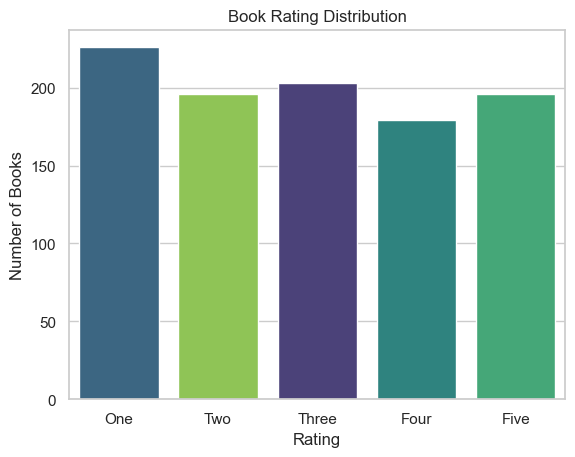

In [17]:
sns.countplot(x="Rating", hue="Rating", data=df, order=["One", "Two", "Three", "Four", "Five"], palette="viridis", legend=False)

plt.title("Book Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Number of Books")
plt.savefig("rating_distribution.png")
plt.show()


###  Price Distribution
Now let’s analyze the distribution of book prices to understand the typical pricing range.


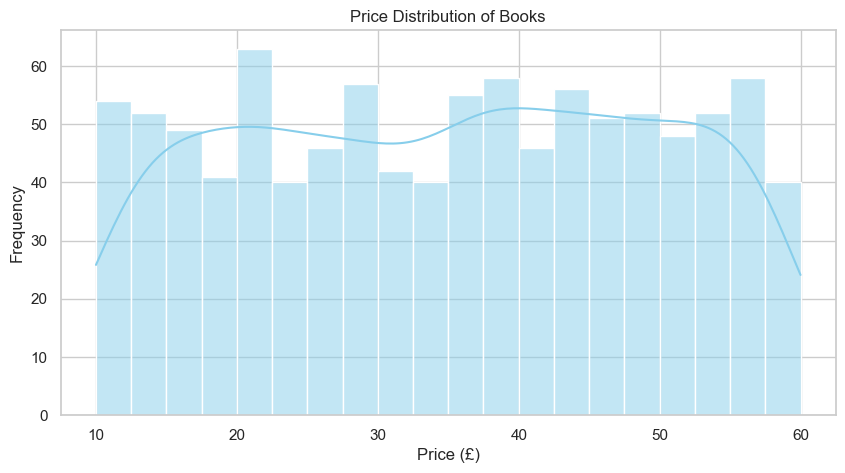

In [11]:
plt.figure(figsize=(10, 5))
sns.histplot(df["Price"], bins=20, kde=True, color="skyblue")
plt.title("Price Distribution of Books")
plt.xlabel("Price (£)")
plt.ylabel("Frequency")
plt.savefig("price_distribution.png")
plt.show()


###  Average Price by Rating
We'll calculate the average book price for each rating category to check if higher-rated books tend to be more expensive.


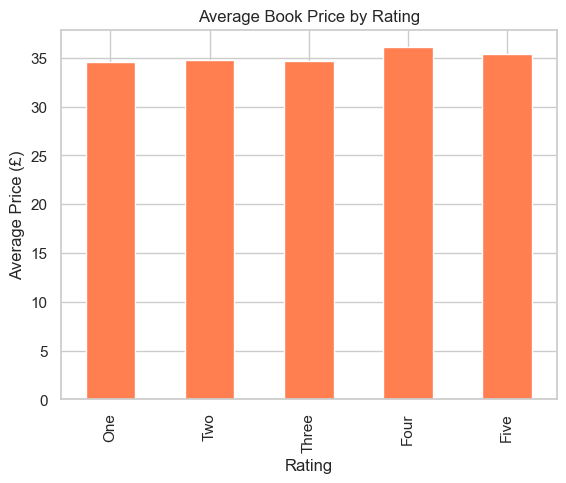

In [12]:
avg_price_rating = df.groupby("Rating")["Price"].mean().reindex(["One", "Two", "Three", "Four", "Five"])
avg_price_rating.plot(kind="bar", color="coral")
plt.title("Average Book Price by Rating")
plt.xlabel("Rating")
plt.ylabel("Average Price (£)")
plt.savefig("avg_price_by_rating.png")
plt.show()


###  Book Availability
Let's explore how many books are listed as "In Stock" or otherwise, and visualize this count.


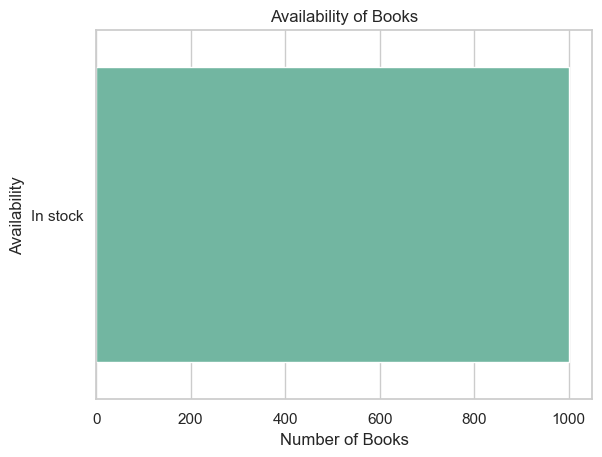

In [18]:
sns.countplot(y="Availability", hue="Availability", data=df, palette="Set2", legend=False)

plt.title("Availability of Books")
plt.xlabel("Number of Books")
plt.ylabel("Availability")
plt.savefig("availability.png")
plt.show()


## Keyword Frequency Analysis
After visualizing book ratings, prices, and availability, we perform a text analysis on the book titles to understand the most commonly used words.

This helps identify patterns or themes in the types of books listed. For instance, frequent keywords like “Story,” “Life,” or “Guide” might indicate popular genres or topics. It adds a layer of natural language insight to our dataset.

We use Counter from Python’s collections module and re for regex-based tokenization.

In [20]:
from collections import Counter
import re

all_words = " ".join(df["Title"]).lower()
word_list = re.findall(r'\b\w+\b', all_words)
word_freq = Counter(word_list)

# Top 10 common words
top_words = dict(word_freq.most_common(10))
pd.DataFrame(list(top_words.items()), columns=["Word", "Frequency"])


,Word,Frequency
0,the,632
1,of,256
2,1,206
3,and,186
4,a,167
5,to,91
6,s,83
7,in,74
8,2,60
9,for,58


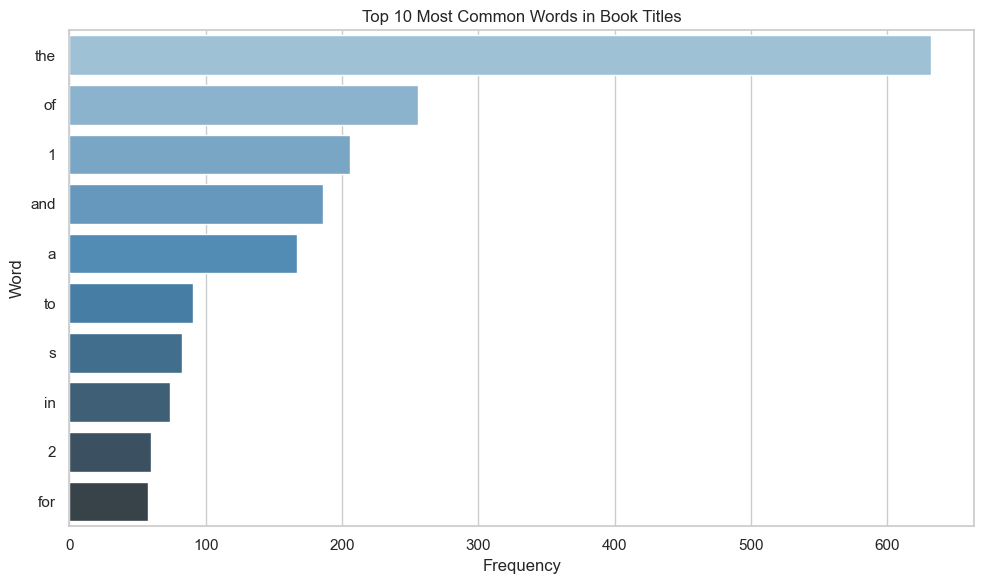

In [22]:
import matplotlib.pyplot as plt

# Create a DataFrame from the top words
top_words_df = pd.DataFrame(list(top_words.items()), columns=["Word", "Frequency"])

plt.figure(figsize=(10, 6))
sns.barplot(
    x="Frequency",
    y="Word",
    hue="Word",  # Assigning the same variable as y
    data=top_words_df,
    palette="Blues_d",
    legend=False  # Prevents redundant legend
)
plt.title("Top 10 Most Common Words in Book Titles")
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.tight_layout()
plt.show()



## Top 5 Most Expensive Books

In [23]:
df.sort_values("Price", ascending=False).head(5)[["Title", "Price", "Rating", "Product_URL"]]


,Title,Price,Rating,Product_URL
648,The Perfect Play (Play by Play #1),59.99,Three,http://books.toscrape.com/catalogue/the-perfec...
617,Last One Home (New Beginnings #1),59.98,Three,http://books.toscrape.com/catalogue/last-one-h...
860,Civilization and Its Discontents,59.95,Two,http://books.toscrape.com/catalogue/civilizati...
560,The Barefoot Contessa Cookbook,59.92,Five,http://books.toscrape.com/catalogue/the-barefo...
366,The Diary of a Young Girl,59.90,Three,http://books.toscrape.com/catalogue/the-diary-...


## Streamlit Dashboard
Creating a simple app to explore data interactively

## 1. streamlit_app.py (Home page + Sidebar Metrics)

In [ ]:
import streamlit as st
import pandas as pd

# Load data once
@st.cache_data
def load_data():
    df = pd.read_csv("all_books.csv")
    df["Price"] = df["Price"].str.replace("£", "").astype(float)
    return df

df = load_data()

st.set_page_config(page_title="Books Dashboard", layout="wide")

# Sidebar with metrics
st.sidebar.title("📚 Books Summary")

total_books = len(df)
avg_price = df["Price"].mean()
unique_ratings = df["Rating"].nunique()
availability_counts = df["Availability"].value_counts().to_dict()

st.sidebar.metric("Total Books", total_books)
st.sidebar.metric("Avg Price (£)", f"{avg_price:.2f}")
st.sidebar.metric("Rating Categories", unique_ratings)
st.sidebar.markdown("### Availability")
for key, val in availability_counts.items():
    st.sidebar.write(f"- {key}: {val}")

# Main page content
st.title("📘 Books Dashboard")
st.markdown("""
Welcome to the **Books to Scrape Dashboard**!

Use the left sidebar to navigate through:
- 🔎 Filter and Explore the Data  
- 📊 Visual Insights  
- 🧠 Word Frequency in Titles

---
""")


## 2. pages/1_Filter_and_Data.py

In [ ]:
import streamlit as st
import pandas as pd

@st.cache_data
def load_data():
    df = pd.read_csv("all_books.csv")
    return df

df = load_data()

st.title("🔍 Filter and Explore Books")

rating_options = df["Rating"].unique().tolist()
availability_options = df["Availability"].unique().tolist()

selected_ratings = st.multiselect("Select Ratings", rating_options, default=rating_options)
selected_avail = st.multiselect("Select Availability", availability_options, default=availability_options)

filtered_df = df[df["Rating"].isin(selected_ratings) & df["Availability"].isin(selected_avail)]

st.dataframe(filtered_df)
st.markdown(f"**Total books after filter: {len(filtered_df)}**")


## 3. pages/2_Visualizations.py

In [ ]:
import streamlit as st
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

sns.set(style="whitegrid")
warnings.simplefilter(action='ignore', category=FutureWarning)

@st.cache_data
def load_data():
    df = pd.read_csv("all_books.csv")
    df["Price"] = df["Price"].str.replace("£", "").astype(float)
    return df

df = load_data()

st.title("📊 Visual Analysis")

with st.expander("⭐ Rating Distribution"):
    fig, ax = plt.subplots()
    sns.countplot(x="Rating", data=df, order=["One", "Two", "Three", "Four", "Five"], hue="Rating", palette="viridis", legend=False)
    ax.set_title("Rating Distribution")
    st.pyplot(fig)

with st.expander("💵 Price Distribution"):
    fig, ax = plt.subplots()
    sns.histplot(df["Price"], bins=20, kde=True, color="skyblue")
    ax.set_title("Price Distribution")
    st.pyplot(fig)

with st.expander("📈 Avg Price by Rating"):
    avg_price = df.groupby("Rating")["Price"].mean().reindex(["One", "Two", "Three", "Four", "Five"])
    fig, ax = plt.subplots()
    avg_price.plot(kind="bar", color="coral", ax=ax)
    ax.set_title("Average Price by Rating")
    st.pyplot(fig)

with st.expander("✅ Book Availability"):
    fig, ax = plt.subplots()
    sns.countplot(y="Availability", data=df, hue="Availability", palette="Set2", legend=False)
    ax.set_title("Book Availability")
    st.pyplot(fig)


## 4. pages/3_Word_Frequency.py

In [ ]:
import streamlit as st
import pandas as pd
from collections import Counter
import re
import seaborn as sns
import matplotlib.pyplot as plt

@st.cache_data
def load_data():
    return pd.read_csv("all_books.csv")

df = load_data()

st.title("🧠 Word Frequency in Titles")

all_words = " ".join(df["Title"]).lower()
word_list = re.findall(r'\b\w+\b', all_words)
word_freq = Counter(word_list)

top_words = dict(word_freq.most_common(10))
top_words_df = pd.DataFrame(list(top_words.items()), columns=["Word", "Frequency"])

st.dataframe(top_words_df)

fig, ax = plt.subplots()
sns.barplot(x="Frequency", y="Word", data=top_words_df, palette="mako")
ax.set_title("Top 10 Common Words in Titles")
st.pyplot(fig)
